In [1]:
# From https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/
%load_ext autoreload
%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
DATAPATH = '../../ufz_im_challenge/photos_annotated'
import sys
sys.path.insert(0,'../')

from src.utils.kerasDataLoader import DataGenerator
import src.utils.keras_losses as Loss

import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

from tensorflow.keras import backend as K
import numpy as np

IMAGESIZE = (224, 224)

/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated;

In [2]:
if os.path.isfile('models/weights/mobilenetweights.h5'):
    MODELPATH = 'models/weights/mobilenetweights.h5'
else:
    if not os.path.isdir('models/weights/'):
        os.makedirs('models/weights/')
    mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    mobilenet.save_weights('models/weights/mobilenetweights.h5')
    MODELPATH = 'models/weights/mobilenetweights.h5'

In [3]:
try:
    from albumentations import (
        HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
        Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
        IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
        IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
    )

    def augmentations(p=0.5):
        return Compose([
            Flip(),
            OneOf([
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),
            ], p=0.3),
            HueSaturationValue(p=0.3),
        ], p=p)
    
except:
        augmentations = None


In [4]:
def make_model(image_size, n_classes = 22, MODELPATH=MODELPATH):
    inputs = Input(shape=(*image_size, 3), name=MODELPATH, name='input_image')
   
    encoder = MobileNetV2(input_tensor=preproc_layer, weights=None, include_top=False, alpha=1.0)
    skip_connection_names = ["input_image", 
                             "block_1_expand_relu", 
                             "block_3_expand_relu", 
                             "block_6_expand_relu"]
    
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [32, 64, 128, 256]
    x = encoder_output
    
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

   # x = tf.keras.layers.Dropout(0.25)(x)
        
    x = Conv2D(n_classes, (1, 1), padding="same")(x)
    x = tf.keras.layers.Softmax(axis=-1)(x)
    
    model = Model(inputs, x)
    return model

In [17]:
model = make_model(image_size=IMAGESIZE)

opt = tf.keras.optimizers.Adam(0.1)

metrics = [Loss.dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(loss=Loss.BCE_dice, optimizer=opt, metrics=metrics)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, verbose=0),
    ModelCheckpoint('models/kerasUnet2', monitor='val_loss', verbose=1, save_best_only=False)
]

In [18]:
train_dataset = DataGenerator(datapath= DATAPATH,  batch_size=32, shuffle=True, augmentation=augmentations, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)
valid_dataset = DataGenerator(datapath= DATAPATH, step='valid', shuffle=False, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)

In [19]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=120,
    callbacks=callbacks
)

Epoch 1/120
83/83 [==============================] - 2s 26ms/step - loss: 1.8112 - dice_coef: 0.6971 - recall_1: 0.6971 - precision_1: 0.6971

Epoch 00001: saving model to models/kerasUnet2
20/20 [==============================] - 46s 2s/step - loss: 24.7064 - dice_coef: 0.5293 - recall_1: 0.4801 - precision_1: 0.8349 - val_loss: 1.8112 - val_dice_coef: 0.6971 - val_recall_1: 0.6971 - val_precision_1: 0.6971
Epoch 2/120
83/83 [==============================] - 1s 13ms/step - loss: 1.8378 - dice_coef: 0.6927 - recall_1: 0.6927 - precision_1: 0.6927

Epoch 00002: saving model to models/kerasUnet2
20/20 [==============================] - 8s 388ms/step - loss: 17.8858 - dice_coef: 0.6435 - recall_1: 0.6244 - precision_1: 0.8308 - val_loss: 1.8378 - val_dice_coef: 0.6927 - val_recall_1: 0.6927 - val_precision_1: 0.6927
Epoch 3/120
83/83 [==============================] - 1s 13ms/step - loss: 1.8642 - dice_coef: 0.6882 - recall_1: 0.6882 - precision_1: 0.6882

Epoch 00003: saving model to mo

In [20]:
test_dataset = DataGenerator(datapath= DATAPATH, step='test', shuffle=False, preprocessing=mobilenet_v2.preprocess_input, image_size=IMAGESIZE)

In [21]:
pred = model.predict(test_dataset)

In [22]:
model.evaluate(test_dataset)

83/83 [==============================] - 1s 12ms/step - loss: 0.4477 - dice_coef: 0.7555 - recall_1: 0.7508 - precision_1: 0.8176


[0.4476926062839577, 0.7554985, 0.750815, 0.8175524]

In [23]:
x = test_dataset.images
y = test_dataset.labels

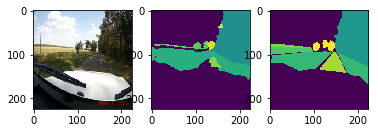

In [24]:
viz_idx = 7
plt.subplot(131)
plt.imshow(x[viz_idx].squeeze())
plt.subplot(132)
plt.imshow(np.argmax(pred[viz_idx], -1).squeeze())
plt.subplot(133)
plt.imshow(np.argmax(y[viz_idx], -1).squeeze())


In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
model.save('models/final_keras')